In [1]:
import requests
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm


In [2]:
def scan_parquet(slug: str) -> pl.LazyFrame:
    response = requests.get(f"https://osf.io/{slug}/download", stream=True)

    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(f"/tmp/{slug}", "wb") as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

    return pl.scan_parquet(f"/tmp/{slug}")


In [3]:
if "CI" not in os.environ:
    df1 = scan_parquet(
        "musp8",
    ).with_columns(
        pl.lit("baseline").alias("what"),
    ).filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).collect()
    len(df1)


In [4]:
if "CI" not in os.environ:
    df2 = scan_parquet(
        "72d6m",
    ).filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).with_columns(
        pl.lit("insertions").alias("what"),
    ).collect()
    len(df2)


In [5]:
if "CI" not in os.environ:
    df3 = scan_parquet(
        "sudfh",
    ).filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).with_columns(
        pl.lit("deletions").alias("what"),
    ).collect()
    len(df3)


In [6]:
if "CI" not in os.environ:
    df = pl.concat(
        [df1.lazy(), df2.lazy(), df3.lazy()],
        how="vertical_relaxed",
    ).collect()


In [7]:
if "CI" not in os.environ:
    df = df.with_columns(
        Components=pl.col("Task").replace_strict(
            {
                "AND": 2,
                "ANDNOT": 3,
                "NAND": 1,
                "NOR": 4,
                "NOT": 1,
                "OR": 3,
                "ORNOT": 2,
                "XOR": 4,
                "EQUALS": 5,
            },
        ),
    )


In [8]:
if "CI" not in os.environ:
    df = df.with_columns(
        (
            pl.col("Components")
            * pl.col("Has Task")
        ).max().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("max components"),
    )


In [9]:
if "CI" not in os.environ:
    df = df.with_columns(
        TaskNumber=pl.col("Task").replace_strict(
            dict(map(reversed, enumerate(df["Task"].unique()))),
        ),
    ).with_columns(
        TaskBit=np.left_shift(1, pl.col("TaskNumber")),
    )


In [10]:
if "CI" not in os.environ:
    df = df.with_columns(
        SetTaskBit=pl.col("TaskBit") * pl.col("Has Task"),
    )


In [11]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("SetTaskBit").bitwise_or().over(
            ["Treatment", "Run ID", "Generation Born", "what"],
        )
        .alias("SetTaskBits"),
    )


In [12]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Is Task Coding Site").any().over(
            ["Treatment", "Run ID", "Generation Born", "Site", "what"],
        )
        .alias("is any coding site"),
    )


In [13]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Has Task").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Site", "what"],
        )
        .alias("num tasks has"),
    )


In [14]:
if "CI" not in os.environ:
    assert df.lazy().group_by(
        ["Treatment", "Run ID", "Generation Born", "what"]
    ).agg(
        pl.col("num tasks has").n_unique(),
    ).select("num tasks has").max().collect().item() == 1


In [15]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("is any coding site").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Task", "what"],
        ).alias("num coding sites"),
    )


In [16]:
if "CI" not in os.environ:
    dfx = df.group_by(
        ["Treatment", "Run ID", "Generation Born", "what"],
    ).first()
else:
    dfx = scan_parquet("8xt2p").collect()
dfx.columns


  0%|          | 0.00/219k [00:00<?, ?B/s]

100%|██████████| 219k/219k [00:00<00:00, 9.59MB/s]

['Treatment',
 'Run ID',
 'Generation Born',
 'what',
 'Task',
 'Genome Length',
 'Lineage Generation Index',
 'Is Task Coding Site',
 'Is Viability Site',
 'Site',
 'Update Analyzed',
 'Has Task',
 'Update Born',
 'Components',
 'max components',
 'TaskNumber',
 'TaskBit',
 'SetTaskBit',
 'SetTaskBits',
 'is any coding site',
 'num tasks has',
 'num coding sites']

In [17]:
dfx.write_parquet("/tmp/indel-effect-nulldist.pqt")


In [18]:
df1_ = dfx.filter(pl.col("what") == "baseline").sort(
    "Treatment", "Run ID", "Generation Born"
)
df2_ = dfx.filter(pl.col("what") == "insertions").sort(
    "Treatment", "Run ID", "Generation Born"
)
df3_ = dfx.filter(pl.col("what") == "deletions").sort(
    "Treatment", "Run ID", "Generation Born"
)


In [19]:
delta_ncs_insertion = (
    df2_["num coding sites"].to_numpy().astype(np.int64)
    - df1_["num coding sites"].to_numpy().astype(np.int64)
)


In [20]:
delta_ncs_deletion = (
    df3_["num coding sites"].to_numpy().astype(np.int64)
    - df1_["num coding sites"].to_numpy().astype(np.int64)
)


In [21]:
delta_nth_insertion = (
    df2_["num tasks has"].to_numpy().astype(np.int64)
    - df1_["num tasks has"].to_numpy().astype(np.int64)
)


In [22]:
delta_nth_deletion = (
    df3_["num tasks has"].to_numpy().astype(np.int64)
    - df1_["num tasks has"].to_numpy().astype(np.int64)
)


In [23]:
delta_tasks_insertion = (
    df2_["SetTaskBits"].to_numpy().astype(np.int64)
    != df1_["SetTaskBits"].to_numpy().astype(np.int64)
)


In [24]:
delta_tasks_deletion = (
    df3_["SetTaskBits"].to_numpy().astype(np.int64)
    != df1_["SetTaskBits"].to_numpy().astype(np.int64)
)


In [25]:
gained_task_insertion = (
    df2_["SetTaskBits"].to_numpy().astype(np.int64)
    & np.invert(df1_["SetTaskBits"].to_numpy().astype(np.int64))
).astype(bool)


In [26]:
gained_task_deletion = (
    df3_["SetTaskBits"].to_numpy().astype(np.int64)
    & np.invert(df1_["SetTaskBits"].to_numpy().astype(np.int64))
).astype(bool)


In [27]:
lost_task_insertion = (
    np.invert(df2_["SetTaskBits"].to_numpy().astype(np.int64))
    & df1_["SetTaskBits"].to_numpy().astype(np.int64)
).astype(bool)


In [28]:
lost_task_deletion = (
    np.invert(df3_["SetTaskBits"].to_numpy().astype(np.int64))
    & df1_["SetTaskBits"].to_numpy().astype(np.int64)
).astype(bool)


In [29]:
fitness_effect_lookup = {
    -1: "deleterious",
    0: "neutral",
    1: "beneficial",
}


In [30]:
fitness_effect_insertion = np.vectorize(fitness_effect_lookup.__getitem__)(
    np.sign(2 * gained_task_insertion - lost_task_insertion),
)


In [31]:
fitness_effect_deletion = np.vectorize(fitness_effect_lookup.__getitem__)(
    np.sign(2 * gained_task_insertion - lost_task_insertion),
)


In [32]:
dfz = pl.concat(
    [
        pl.DataFrame(
            {
                "Treatment": df1_["Treatment"],
                "Run ID": df1_["Run ID"],
                "Generation Born": df1_["Generation Born"],
                "what": "insertion",
                "delta num coding sites": delta_ncs_insertion,
                "delta num tasks has": delta_nth_insertion,
                "num tasks has": df1_["num tasks has"],
                "num coding sites": df1_["num coding sites"],
                "delta tasks": delta_tasks_insertion,
                "gained task": gained_task_insertion,
                "lost task": gained_task_insertion,
                "max components": df1_["max components"],
                "fitness effect": fitness_effect_insertion,
            },
        ),
        # disable deletion outputs, as they are not of interest
        # pl.DataFrame(
        #     {
        #         "Treatment": df1_["Treatment"],
        #         "Run ID": df1_["Run ID"],
        #         "Generation Born": df1_["Generation Born"],
        #         "what": "deletion",
        #         "delta num coding sites": delta_ncs_deletion,
        #         "delta num tasks has": delta_nth_deletion,
        #         "num tasks has": df1_["num tasks has"],
        #         "num coding sites": df1_["num coding sites"],
        #         "delta tasks": delta_tasks_deletion,
        #         "gained task": gained_task_deletion,
        #         "lost task": lost_task_deletion,
        #         "max components": df1_["max components"],
        #         "fitness effect": fitness_effect_deletion,
        #     },
        # ),
    ],
)
dfz


Treatment,Run ID,Generation Born,what,delta num coding sites,delta num tasks has,num tasks has,num coding sites,delta tasks,gained task,lost task,max components,fitness effect
str,str,i64,str,i64,i64,u32,u32,bool,bool,bool,i64,str
"""Slip-duplicate""","""run_1590""",0,"""insertion""",0,0,0,0,false,false,false,0,"""neutral"""
"""Slip-duplicate""","""run_1590""",12,"""insertion""",0,0,0,0,false,false,false,0,"""neutral"""
"""Slip-duplicate""","""run_1590""",18,"""insertion""",0,0,0,0,false,false,false,0,"""neutral"""
"""Slip-duplicate""","""run_1590""",28,"""insertion""",0,0,0,0,false,false,false,0,"""neutral"""
"""Slip-duplicate""","""run_1590""",34,"""insertion""",0,0,0,0,false,false,false,0,"""neutral"""
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Slip-duplicate""","""run_1619""",1674,"""insertion""",-5,-1,9,82,true,false,false,5,"""deleterious"""
"""Slip-duplicate""","""run_1619""",1680,"""insertion""",-79,-9,9,83,true,false,false,5,"""deleterious"""
"""Slip-duplicate""","""run_1619""",1685,"""insertion""",-79,-9,9,83,true,false,false,5,"""deleterious"""


In [33]:
dfz.to_pandas()


,Treatment,Run ID,Generation Born,what,delta num coding sites,delta num tasks has,num tasks has,num coding sites,delta tasks,gained task,lost task,max components,fitness effect
0,Slip-duplicate,run_1590,0,insertion,0,0,0,0,False,False,False,0,neutral
1,Slip-duplicate,run_1590,12,insertion,0,0,0,0,False,False,False,0,neutral
2,Slip-duplicate,run_1590,18,insertion,0,0,0,0,False,False,False,0,neutral
3,Slip-duplicate,run_1590,28,insertion,0,0,0,0,False,False,False,0,neutral
4,Slip-duplicate,run_1590,34,insertion,0,0,0,0,False,False,False,0,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,Slip-duplicate,run_1619,1674,insertion,-5,-1,9,82,True,False,False,5,deleterious
7399,Slip-duplicate,run_1619,1680,insertion,-79,-9,9,83,True,False,False,5,deleterious
7400,Slip-duplicate,run_1619,1685,insertion,-79,-9,9,83,True,False,False,5,deleterious
7401,Slip-duplicate,run_1619,1686,insertion,-83,-9,9,83,True,False,False,5,deleterious


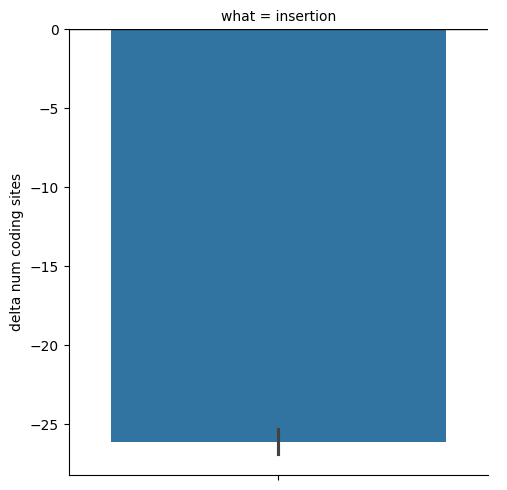

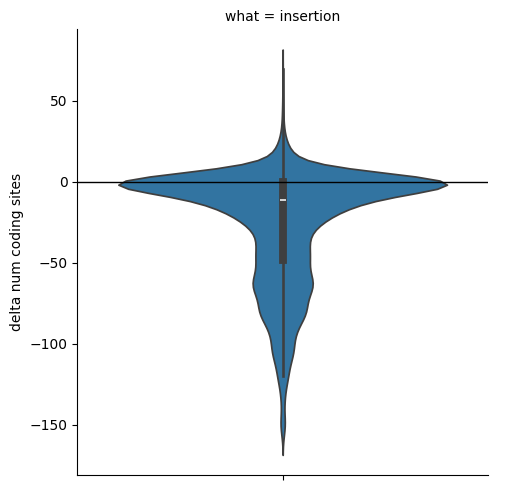

In [34]:
for kind in "bar", "violin":
    saveit, g = tp.tee(
        sns.catplot,
        data=dfz.to_pandas(),
        col="what",
        y="delta num coding sites",
        kind=kind,
        teeplot_callback=True,
    )
    for ax in g.axes.flat:
        ax.axhline(0, color="black", linewidth=1)


(np.float64(-7.2994923857868015), np.float64(-6.408943678994441))
(np.float64(0.9508064516129033), np.float64(7.936693548387096))
(np.float64(-52.789770599250936), np.float64(-50.20929307116105))
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


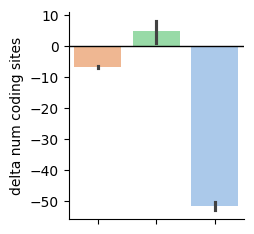

(np.float64(-27.0), np.float64(16.0))
(np.float64(-11.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-16.0), np.float64(28.0))
(np.float64(0.25), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-157.0), np.float64(58.0))
(np.float64(-78.0), np.float64(-17.0))
(np.float64(-53.0), np.float64(-53.0))
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


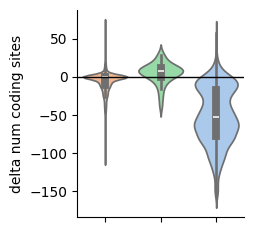

(np.float64(-7.253474740149867), np.float64(-6.380070099105632))
(np.float64(1.2096774193548387), np.float64(7.790322580645161))
(np.float64(-52.828105493133585), np.float64(-50.15128745318352))
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


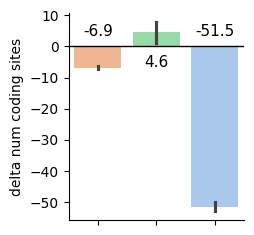

(np.float64(-27.0), np.float64(16.0))
(np.float64(-11.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-16.0), np.float64(28.0))
(np.float64(0.25), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-157.0), np.float64(58.0))
(np.float64(-78.0), np.float64(-17.0))
(np.float64(-53.0), np.float64(-53.0))
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


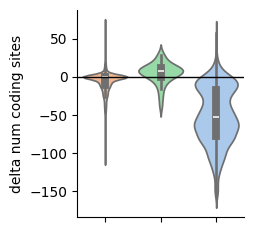

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=probability+viz=displot+x=fitness-effect+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=probability+viz=displot+x=fitness-effect+ext=.png


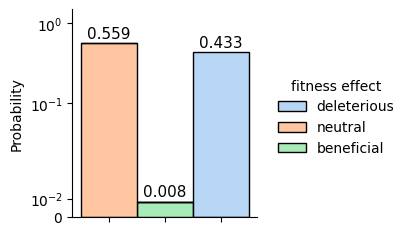

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=count+viz=displot+x=fitness-effect+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=count+viz=displot+x=fitness-effect+ext=.png


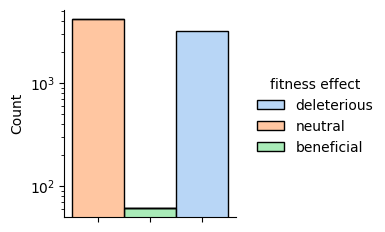

(np.float64(0.031413612565445025), np.float64(0.12303664921465969))
(np.float64(-8.108088235294117), np.float64(-6.136764705882354))
(np.float64(-0.15182584269662922), np.float64(1.264325842696629))
(np.float64(5.555555555555555), np.float64(9.11111111111111))
(np.float64(-15.87908163265306), np.float64(-12.183163265306124))
(np.float64(-3.8603711790393014), np.float64(-2.1875545851528386))
(np.float64(4.090909090909091), np.float64(13.913636363636359))
(np.float64(-24.967977528089886), np.float64(-18.27233146067416))
(np.float64(-5.497790697674419), np.float64(-3.425581395348837))
(np.float64(-7.609782608695652), np.float64(6.828260869565216))
(np.float64(-49.47990495587237), np.float64(-46.61770196877122))
(np.float64(-9.952691256830601), np.float64(-8.53483606557377))
(np.float64(-0.9411764705882353), np.float64(12.060294117647057))
(np.float64(-67.54920546932742), np.float64(-63.33024759793052))
(np.float64(-9.299011948529412), np.float64(-7.271116727941177))
(np.float64(0.0), np.f

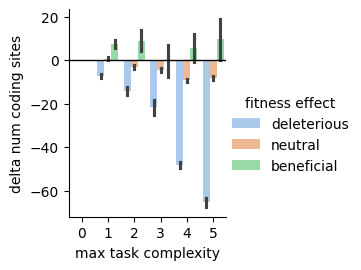

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(12.0))
(np.float64(6.0), np.float64(9.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-32.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.25))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-12.0), np.float64(7.0))
(np.float64(-5.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(21.0))
(np.float64(3.0), np.float64(12.5))
(np.float64(6.0), np.float64(6.0))
(np.float64(-73.0), np.float64(36.0))
(np.float64(-37.0), np.float64(-4.0))
(np.float64(-17.5), np.float64(-17.5))
(np.float64(-22.0), np.float64(13.0))
(np.float64(-9.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-26.

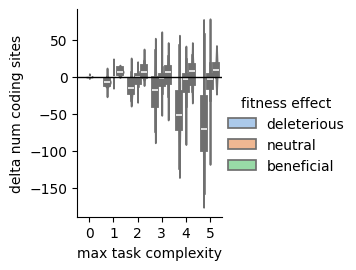

(np.float64(0.031413612565445025), np.float64(0.12571989528795804))
(np.float64(-8.147303921568627), np.float64(-6.137254901960785))
(np.float64(-0.11249999999999999), np.float64(1.2865168539325842))
(np.float64(5.66388888888889), np.float64(9.224999999999996))
(np.float64(-15.989795918367347), np.float64(-12.10204081632653))
(np.float64(-3.8209606986899565), np.float64(-2.1222707423580784))
(np.float64(4.454545454545454), np.float64(13.909090909090908))
(np.float64(-24.989185393258428), np.float64(-18.005477528089887))
(np.float64(-5.47953488372093), np.float64(-3.4719767441860463))
(np.float64(-6.914130434782608), np.float64(7.436956521739129))
(np.float64(-49.52416836388323), np.float64(-46.616055668703325))
(np.float64(-9.899098360655737), np.float64(-8.489549180327868))
(np.float64(-0.6485294117647058), np.float64(12.060294117647057))
(np.float64(-67.58667775314117), np.float64(-63.12463045084996))
(np.float64(-9.245335477941175), np.float64(-7.209030330882354))
(np.float64(0.0), 

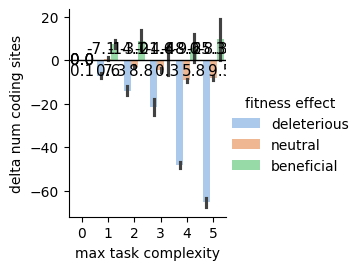

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(12.0))
(np.float64(6.0), np.float64(9.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-32.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.25))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-12.0), np.float64(7.0))
(np.float64(-5.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(21.0))
(np.float64(3.0), np.float64(12.5))
(np.float64(6.0), np.float64(6.0))
(np.float64(-73.0), np.float64(36.0))
(np.float64(-37.0), np.float64(-4.0))
(np.float64(-17.5), np.float64(-17.5))
(np.float64(-22.0), np.float64(13.0))
(np.float64(-9.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-26.

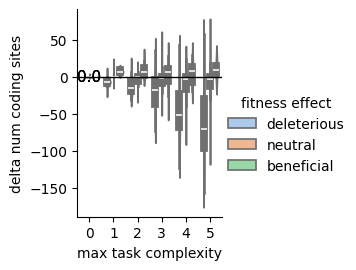

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=max-components+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=max-components+ext=.png


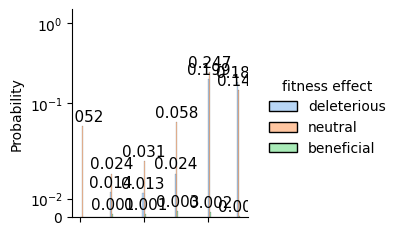

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=max-components+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=max-components+ext=.png


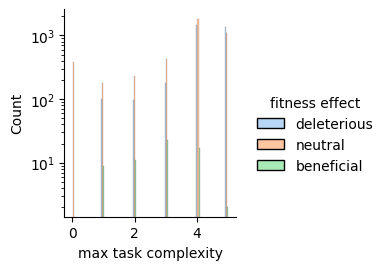

(np.float64(0.031413612565445025), np.float64(0.12833769633507847))
(np.float64(6.0), np.float64(9.75))
(np.float64(-7.406976744186046), np.float64(-5.895058139534884))
(np.float64(-0.3400326797385621), np.float64(1.1700980392156861))
(np.float64(5.769230769230769), np.float64(12.307692307692308))
(np.float64(-14.385576923076924), np.float64(-8.076923076923077))
(np.float64(-2.622256097560976), np.float64(-0.26768292682926886))
(np.float64(0.6666666666666666), np.float64(16.0))
(np.float64(-15.348837209302326), np.float64(-11.499709302325583))
(np.float64(-3.18562874251497), np.float64(-0.8381736526946109))
(np.float64(-15.680555555555554), np.float64(7.555555555555555))
(np.float64(-20.08672839506173), np.float64(-13.18456790123457))
(np.float64(-4.411014851485149), np.float64(-1.9652227722772277))
(np.float64(-8.642857142857142), np.float64(9.785714285714286))
(np.float64(-28.700342465753426), np.float64(-19.903424657534245))
(np.float64(-7.000308641975309), np.float64(-3.93827160493

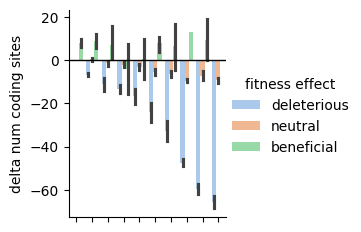

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(6.0), np.float64(11.0))
(np.float64(6.0), np.float64(8.75))
(np.float64(7.0), np.float64(7.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(-1.0), np.float64(2.0))
(np.float64(0.0), np.float64(1.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(21.0))
(np.float64(4.0), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-23.0), np.float64(2.0))
(np.float64(-16.75), np.float64(-7.0))
(np.float64(-11.5), np.float64(-11.5))
(np.float64(-5.0), np.float64(3.0))
(np.float64(-2.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(9.0))
(np.float64(-0.5), np.float64(8.5))
(np.float64(4.0), np.float64(4.0))
(np.float64(-31.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.0))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-9.0), np

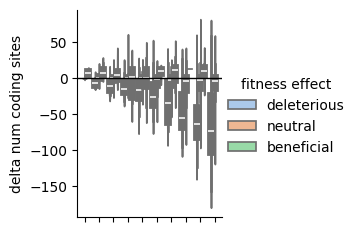

(np.float64(0.031413612565445025), np.float64(0.1256544502617801))
(np.float64(6.0), np.float64(10.25))
(np.float64(-7.302616279069767), np.float64(-5.77906976744186))
(np.float64(-0.23529411764705882), np.float64(1.2098039215686267))
(np.float64(5.615384615384615), np.float64(12.155769230769229))
(np.float64(-13.923076923076923), np.float64(-7.921153846153848))
(np.float64(-2.6341463414634148), np.float64(-0.17073170731707318))
(np.float64(0.6583333333333338), np.float64(14.666666666666666))
(np.float64(-15.221511627906976), np.float64(-11.359883720930233))
(np.float64(-3.2516467065868264), np.float64(-0.7660179640718567))
(np.float64(-15.45), np.float64(6.888888888888889))
(np.float64(-20.012962962962963), np.float64(-12.937345679012347))
(np.float64(-4.312747524752475), np.float64(-2.0045792079207922))
(np.float64(-8.285714285714286), np.float64(9.571428571428571))
(np.float64(-28.48013698630137), np.float64(-19.505479452054796))
(np.float64(-7.006327160493827), np.float64(-3.956481

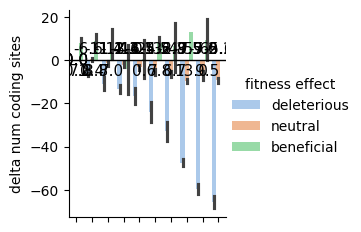

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(6.0), np.float64(11.0))
(np.float64(6.0), np.float64(8.75))
(np.float64(7.0), np.float64(7.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(-1.0), np.float64(2.0))
(np.float64(0.0), np.float64(1.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(21.0))
(np.float64(4.0), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-23.0), np.float64(2.0))
(np.float64(-16.75), np.float64(-7.0))
(np.float64(-11.5), np.float64(-11.5))
(np.float64(-5.0), np.float64(3.0))
(np.float64(-2.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(9.0))
(np.float64(-0.5), np.float64(8.5))
(np.float64(4.0), np.float64(4.0))
(np.float64(-31.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.0))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-9.0), np

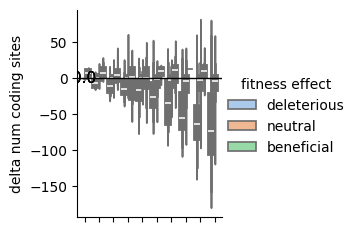

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=num-tasks-has+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=num-tasks-has+ext=.png


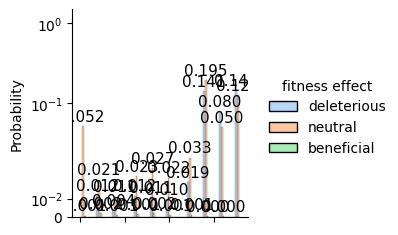

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=num-tasks-has+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=num-tasks-has+ext=.png


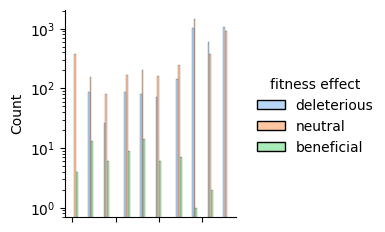

In [35]:
for x in "fitness effect", "max components", "num tasks has":
    for kind in "bar", "violin":
        saveit, g = tp.tee(
            sns.catplot,
            data=dfz.to_pandas(),
            col="what",
            x=x,
            y="delta num coding sites",
            hue="fitness effect",
            hue_order=["deleterious", "neutral", "beneficial"],
            kind=kind,
            palette="pastel",
            teeplot_callback=True,
            aspect=0.9,
            height=3,
        )
        if x != "max components":
            g.set(xticklabels=[], xlabel="")
        else:
            g.set(xlabel="max task complexity")
        g.set_titles("")
        for ax in g.axes.flat:
            xs = [line.get_xdata().min() for line in ax.lines]
            lower = [line.get_ydata().min() for line in ax.lines]
            upper = [line.get_ydata().max() for line in ax.lines]
            cis = [*zip(lower, upper)]
            order = np.argsort(xs)
            for o in order:
                print(cis[o])
            ax.axhline(0, color="black", linewidth=1)
        saveit()

    for kind in "bar", "violin":
        saveit, g = tp.tee(
            sns.catplot,
            data=dfz.to_pandas(),
            col="what",
            x=x,
            y="delta num coding sites",
            hue="fitness effect",
            hue_order=["deleterious", "neutral", "beneficial"],
            kind=kind,
            palette="pastel",
            teeplot_callback=True,
            teeplot_outattrs={"textlabels": True},
            aspect=0.9,
            height=3,
        )
        if x != "max components":
            g.set(xticklabels=[], xlabel="")
        else:
            g.set(xlabel="max task complexity")
        g.set_titles("")
        for ax in g.axes.flat:
            xs = [line.get_xdata().min() for line in ax.lines]
            lower = [line.get_ydata().min() for line in ax.lines]
            upper = [line.get_ydata().max() for line in ax.lines]
            cis = [*zip(lower, upper)]
            order = np.argsort(xs)
            for o in order:
                print(cis[o])
            ax.axhline(0, color="black", linewidth=1)
            # add count labels
            # adapted from https://stackoverflow.com/a/55319634/17332200
            for p in ax.patches:
                ax.annotate(
                    text=f"{p.get_height():1.1f}",
                    xy=(
                        p.get_x() + p.get_width() / 2.,
                        -5 * np.sign(p.get_height())
                    ),
                    xycoords="data",
                    ha="center",
                    va="center",
                    fontsize=11,
                    color="black",
                    xytext=(0,0),
                    textcoords="offset points",
                    clip_on=True,                   # <---  important
                )
        saveit()

    saveit, g = tp.tee(
        sns.displot,
        data=dfz.to_pandas(),
        col="what",
        x=x,
        kind="hist",
        hue="fitness effect",
        hue_order=["deleterious", "neutral", "beneficial"],
        multiple="stack" if x == "fitness effect" else "dodge",
        palette="pastel",
        stat="probability",
        teeplot_callback=True,
        aspect=0.9,
        height=3,
    )
    plt.yscale("symlog", linthresh=5e-2)
    g.set(xticklabels=[], xlabel="", ylim=(0, 1.5))
    g.set_titles("")

    # add count labels
    # adapted from https://stackoverflow.com/a/55319634/17332200
    for ax in g.axes.flat:
        xs = [line.get_xdata().min() for line in ax.lines]
        lower = [line.get_ydata().min() for line in ax.lines]
        upper = [line.get_ydata().max() for line in ax.lines]
        cis = [*zip(lower, upper)]
        order = np.argsort(xs)
        for o in order:
            print(cis[o])

        for p in ax.patches:
            if p.get_height() > 0.0001:
                ax.annotate(
                    text=f"{p.get_height():1.3f}",
                    xy=(
                        p.get_x() + p.get_width() / 2.,
                        p.get_height(),
                    ),
                    xycoords="data",
                    ha="center",
                    va="center",
                    fontsize=11,
                    color="black",
                    xytext=(0,7),
                    textcoords="offset points",
                    clip_on=True,                   # <---  important
                )

    saveit()

    saveit, g = tp.tee(
        sns.displot,
        data=dfz.to_pandas(),
        col="what",
        x=x,
        kind="hist",
        hue="fitness effect",
        hue_order=["deleterious", "neutral", "beneficial"],
        stat="count",
        palette="pastel",
        multiple="stack" if x == "fitness effect" else "dodge",
        teeplot_callback=True,
        aspect=0.9,
        height=3,
    )
    plt.yscale("log")
    if x != "max components":
        g.set(xticklabels=[], xlabel="")
    else:
        g.set(xlabel="max task complexity")
    g.set_titles("")

    # add count labels
    # adapted from https://stackoverflow.com/a/55319634/17332200
    for ax in g.axes.flat:
        xs = [line.get_xdata().min() for line in ax.lines]
        lower = [line.get_ydata().min() for line in ax.lines]
        upper = [line.get_ydata().max() for line in ax.lines]
        cis = [*zip(lower, upper)]
        order = np.argsort(xs)
        for o in order:
            print(cis[o])

        for p in ax.patches:
            ax.annotate(
                text=f"{p.get_height():1.0f}",
                xy=(
                    p.get_x() + p.get_width() / 2.,
                    -5 * np.sign(p.get_height()),
                ),
                xycoords="data",
                ha="center",
                va="center",
                fontsize=11,
                color="black",
                xytext=(0,0),
                textcoords="offset points",
                clip_on=True,                   # <---  important
            )

    saveit()


teeplots/col=num-tasks-has+kind=hist+row=what+viz=displot+x=delta-num-coding-sites+y=delta-num-tasks-has+ext=.pdf


teeplots/col=num-tasks-has+kind=hist+row=what+viz=displot+x=delta-num-coding-sites+y=delta-num-tasks-has+ext=.png


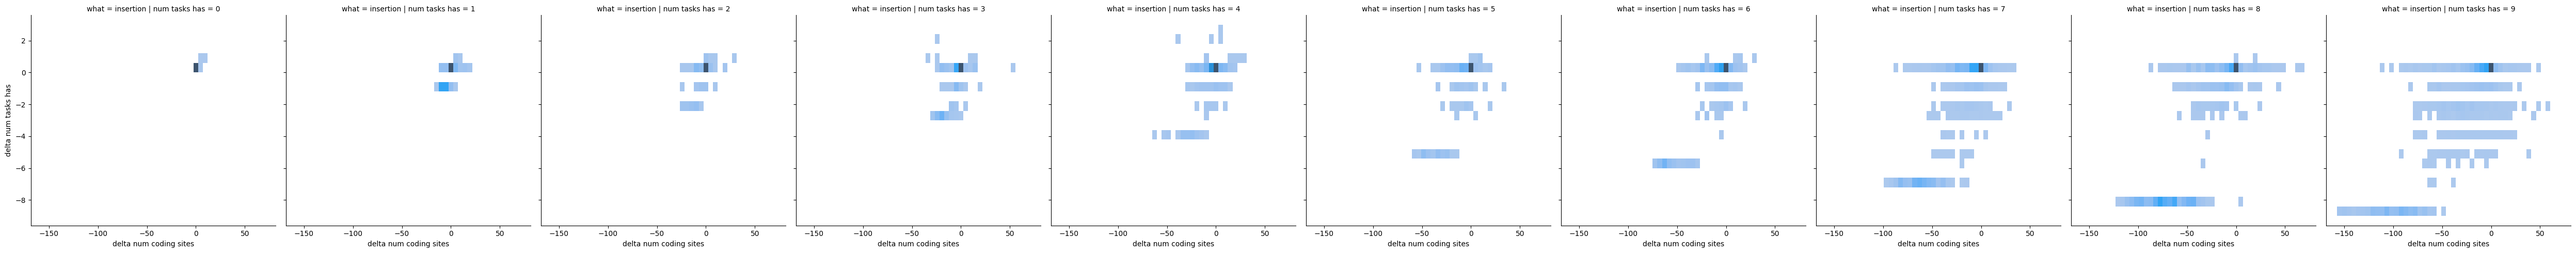

In [36]:
tp.tee(
    sns.displot,
    data=dfz.to_pandas(),
    x="delta num coding sites",
    y="delta num tasks has",
    row="what",
    common_norm=False,
    col="num tasks has",
    kind="hist",
)
